# Biased and Unbiased Fractals

Finding a phase transition, this time in 2D!!


In [1]:
import jax
import jax.numpy as jnp
from jax import random
import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np

In [20]:
def random_walk_only_last(key, xbias=0.0, ybias=0.0, time=100):
    if time <= 1:
        return jnp.array([0.0, 0.0])

    #note that I have changed the definition of the bias
    p_right = 0.25 * (1 + xbias)
    p_left = 0.25 * (1 - xbias)
    p_up = 0.25 * (1 + ybias)
    p_down = 0.25 * (1 - ybias)

    probs = jnp.array([p_right, p_left, p_up, p_down])
    movements = jnp.array([[1, 0], [-1, 0], [0, 1], [0, -1]])

    key, subkey = random.split(key)
    step_indices = random.choice(subkey, 4, shape=(time - 1,), p=probs)
    steps = movements[step_indices]
    position = jnp.sum(steps, axis=0)

    return position

def find_slope(xbias, ybias, time_range=100, N=10):
    initial_key = random.PRNGKey(0)
    r_meansquare = []
    t = []

    for time in range(1, time_range):
        t.append(time)
        r_temp = []
        key = initial_key

        for _ in range(N):
            key, subkey = random.split(key)
            final_position = random_walk_only_last(subkey, xbias=xbias, ybias=ybias, time=time)
            r_squared = jnp.sum(final_position ** 2)
            r_temp.append(r_squared)

        mean_r_square = jnp.mean(jnp.array(r_temp))
        r_meansquare.append(mean_r_square)

    r_rms = jnp.sqrt(jnp.array(r_meansquare))

    #log of zero is not very nice
    log_r_rms = jnp.log(r_rms[1:])
    log_t = jnp.log(jnp.array(t[1:]))

    slope, intercept, r, p, std_err = stats.linregress(log_t, log_r_rms)
    return slope

print('exponent = ', find_slope(xbias=0.0, ybias=0.0, time_range=100, N=50))

exponent =  0.5727282312922725


In [30]:
#super slowww
'''
biases = np.linspace(-3, 3, 7)
eponts = []
for i in range(len(biases)):
    for j in range(len(biases)):
        eponts.append(find_slope(xbias=biases[i], ybias=biases[j], time_range=100, N=10))


fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(biases, biases, eponts, marker='m')

ax.set_xlabel('xbias')
ax.set_ylabel('ybias')
ax.set_zlabel('Exponent')

plt.show()
'''

"\nbiases = np.linspace(-3, 3, 7)\neponts = []\nfor i in range(len(biases)):\n    for j in range(len(biases)):\n        eponts.append(find_slope(xbias=biases[i], ybias=biases[j], time_range=100, N=10))\n\n\nfig = plt.figure()\nax = fig.add_subplot(projection='3d')\nax.scatter(biases, biases, eponts, marker='m')\n\nax.set_xlabel('xbias')\nax.set_ylabel('ybias')\nax.set_zlabel('Exponent')\n\nplt.show()\n"

In [24]:
def jax_linregress(x, y):
    n = x.shape[0]
    x_mean = jnp.mean(x)
    y_mean = jnp.mean(y)

    numerator = jnp.sum((x - x_mean) * (y - y_mean))
    denominator = jnp.sum((x - x_mean) ** 2)
    slope = numerator / denominator

    return slope

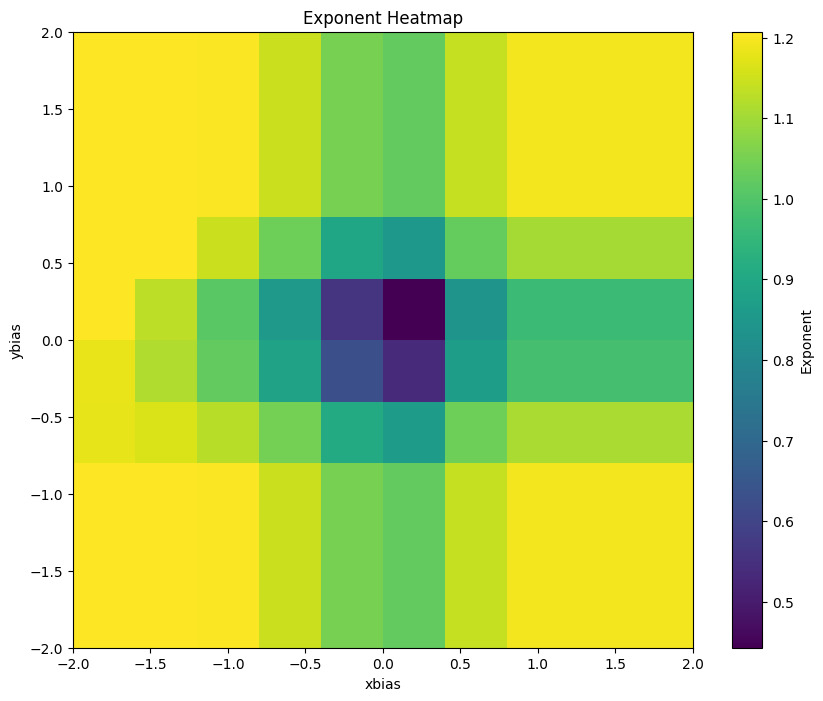

In [29]:
def find_slope_vectorized(xbias, ybias, time_range=10, N=10):
    initial_key = random.PRNGKey(0)
    r_meansquare = []
    t = []

    for time in range(1, time_range):
        t.append(time)
        key = initial_key
        r_temp = []

        for _ in range(N):
            key, subkey = random.split(key)
            final_position = random_walk_only_last(subkey, xbias=xbias, ybias=ybias, time=time)
            r_squared = jnp.sum(final_position ** 2)
            r_temp.append(r_squared)

        mean_r_square = jnp.mean(jnp.array(r_temp))
        r_meansquare.append(mean_r_square)

    r_rms = jnp.sqrt(jnp.array(r_meansquare))
    log_r_rms = jnp.log(r_rms[1:])
    log_t = jnp.log(jnp.array(t[1:]))

    slope = jax_linregress(log_t, log_r_rms)
    return slope

# asked claude how to do this part, I am still learning more about vmapping
find_slope_parallel = jax.vmap(
    jax.vmap(find_slope_vectorized, in_axes=(None, 0)),  # Vectorize over ybias
    in_axes=(0, None)  # Vectorize over xbias
)

biases = jnp.linspace(-2, 2, 10)
exponents = find_slope_parallel(biases, biases)

#plotting in 3D, looks super cool, still can't decide what looks better though
plt.figure(figsize=(10, 8))
plt.imshow(exponents, extent=[biases.min(), biases.max(), biases.min(), biases.max()], origin='lower', aspect='auto')
plt.colorbar(label='Exponent')
plt.xlabel('xbias')
plt.ylabel('ybias')
plt.title('Exponent Heatmap')
plt.show()